## Plot posteior

In [9]:
""" 
IMPORTS
"""
import json
import os
import sys

import matplotlib.pyplot as plt
import numpy as np

sys.path.append('../')
from plotting_utils import load_glmhmm_data, load_cv_arr, load_data, \
    get_file_name_for_best_model_fold, partition_data_by_session, \
    create_violation_mask, get_marginal_posterior, get_was_correct

In [19]:
""" 
PARAMETERS
"""
animal = "DY_012"
K = 3
num_bins = 10
data_dir = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/GLMHMM/data_for_cluster/'
processed_ibl_data_path = data_dir + "data_by_bin" + str(num_bins) + "global_normalization/"


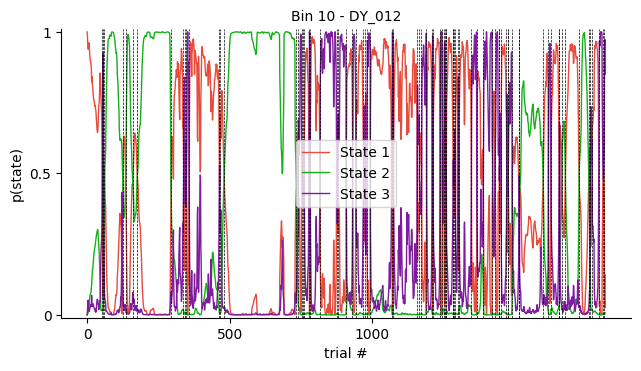

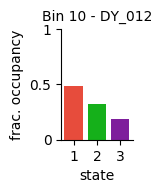

In [23]:

bins_interest = [9]
title = "Bin 10 - DY_012"
for b, bin in enumerate(bins_interest):

    results_dir = '../../results/ibl_individual_fit/' + animal + '_' + str(bin+1) 
    figure_dir = '../../figures/figure_3/'
    if not os.path.exists(figure_dir):
        os.makedirs(figure_dir)

    np.random.seed(59)

    cv_file = results_dir + "/cvbt_folds_model.npz"
    cvbt_folds_model = load_cv_arr(cv_file)

    with open(results_dir + "/best_init_cvbt_dict.json", 'r') as f:
        best_init_cvbt_dict = json.load(f)

    # Get the file name corresponding to the best initialization for given K
    # value
    raw_file = get_file_name_for_best_model_fold(cvbt_folds_model, K,
                                                 results_dir,
                                                 best_init_cvbt_dict)
    hmm_params, lls = load_glmhmm_data(raw_file)

    # Save parameters for initializing individual fits
    weight_vectors = hmm_params[2]
    log_transition_matrix = hmm_params[1][0]
    init_state_dist = hmm_params[0][0]

    # Also get data for animal:
    inpt, y, bin_data = load_data(processed_ibl_data_path + animal + '_bin_' + str(bin+1) + '_processed.npz')
    all_bins = np.unique(bin_data)
    
    # Create mask:
    # Identify violations for exclusion:
    violation_idx = np.where(y == -1)[0]
    nonviolation_idx, mask = create_violation_mask(violation_idx,
                                                   inpt.shape[0])
    y[np.where(y == -1), :] = 1
    inputs, datas, train_masks = partition_data_by_session(
        np.hstack((inpt, np.ones((len(inpt), 1)))), y, mask,
        bin_data)

    posterior_probs = get_marginal_posterior(inputs, datas, train_masks,
                                             hmm_params, K, range(K))
    states_max_posterior = np.argmax(posterior_probs, axis=1)


    bins_to_plot = bins_interest

    cols = ["#e74c3c", "#15b01a", "#7e1e9c", "#3498db", "#f97306"]

    fig = plt.figure(figsize=(25, 18))
    plt.subplots_adjust(wspace=0.2, hspace=0.9)

    for i, bin_n in enumerate(bins_to_plot):
        plt.subplot(3, 3, i + 1)
        idx_bin = np.where(bin_data == bin_n)
        this_inpt = inpt[idx_bin[0], :]
        posterior_probs_this_bin = posterior_probs[idx_bin[0], :]
        # Plot trial structure for this bin too:
        for k in range(K):
            plt.plot(posterior_probs_this_bin[:, k],
                     label="State " + str(k + 1), lw=1,
                     color=cols[k])
        plt.legend()
        states_this_bin = states_max_posterior[idx_bin[0]]
        state_change_locs = np.where(np.abs(np.diff(states_this_bin)) > 0)[0]
        for change_loc in state_change_locs:

            plt.axvline(x=change_loc, color='k', lw=0.5, linestyle='--')
        if i == 0:
            plt.xticks([0, 500, 1000], ["0", "500", "1000"], fontsize=10)
            plt.yticks([0, 0.5, 1], ["0", "0.5", "1"], fontsize=10)
        else:
            plt.xticks([0,  200, 400], ["", "", ""], fontsize=10)
            plt.yticks([0, 0.5, 1], ["", "", ""], fontsize=10)
        plt.ylim((-0.01, 1.01))
        plt.title(title , fontsize=10)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        if i == 0:
            plt.xlabel("trial #", fontsize=10)
            plt.ylabel("p(state)", fontsize=10)




        state_occupancies = []

        for k in range(K):
            # Get state occupancy:
            occ = len(
                np.where(states_max_posterior == k)[0]) / len(states_max_posterior)
            state_occupancies.append(occ)

        # ====================== PLOTTING CODE ===============================
        fig = plt.figure(figsize=(1.3, 1.7))
        plt.subplots_adjust(left=0.4, bottom=0.3, right=0.95, top=0.95)
        for z, occ in enumerate(state_occupancies):
            plt.bar(z, occ, width=0.8, color=cols[z])
        plt.ylim((0, 1))
        plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize=10)
        plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
        plt.xlabel('state', fontsize=10)
        plt.ylabel('frac. occupancy', fontsize=10)  #, labelpad=0.5)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.title(title , fontsize=10)
        fig.savefig(figure_dir + 'fig3d.pdf')


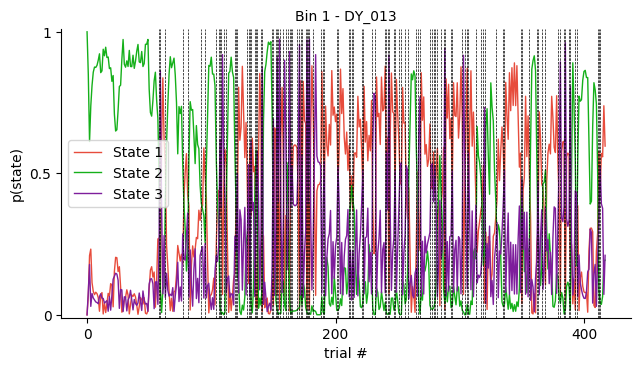

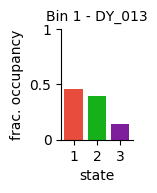

In [8]:

bins_interest = [0]
for b, bin in enumerate(bins_interest):

    results_dir = '../../results/ibl_individual_fit/' + animal + '_' + str(bin+1) 
    figure_dir = '../../figures/figure_3/'
    if not os.path.exists(figure_dir):
        os.makedirs(figure_dir)

    np.random.seed(59)

    cv_file = results_dir + "/cvbt_folds_model.npz"
    cvbt_folds_model = load_cv_arr(cv_file)

    with open(results_dir + "/best_init_cvbt_dict.json", 'r') as f:
        best_init_cvbt_dict = json.load(f)

    # Get the file name corresponding to the best initialization for given K
    # value
    raw_file = get_file_name_for_best_model_fold(cvbt_folds_model, K,
                                                 results_dir,
                                                 best_init_cvbt_dict)
    hmm_params, lls = load_glmhmm_data(raw_file)

    # Save parameters for initializing individual fits
    weight_vectors = hmm_params[2]
    log_transition_matrix = hmm_params[1][0]
    init_state_dist = hmm_params[0][0]

    # Also get data for animal:
    inpt, y, bin_data = load_data(processed_ibl_data_path + animal + '_bin_' + str(bin+1) + '_processed.npz')
    all_bins = np.unique(bin_data)
    
    # Create mask:
    # Identify violations for exclusion:
    violation_idx = np.where(y == -1)[0]
    nonviolation_idx, mask = create_violation_mask(violation_idx,
                                                   inpt.shape[0])
    y[np.where(y == -1), :] = 1
    inputs, datas, train_masks = partition_data_by_session(
        np.hstack((inpt, np.ones((len(inpt), 1)))), y, mask,
        bin_data)

    posterior_probs = get_marginal_posterior(inputs, datas, train_masks,
                                             hmm_params, K, range(K))
    states_max_posterior = np.argmax(posterior_probs, axis=1)


    bins_to_plot = bins_interest

    cols = ["#e74c3c", "#15b01a", "#7e1e9c", "#3498db", "#f97306"]

    fig = plt.figure(figsize=(25, 18))
    plt.subplots_adjust(wspace=0.2, hspace=0.9)

    for i, bin_n in enumerate(bins_to_plot):
        plt.subplot(3, 3, i + 1)
        idx_bin = np.where(bin_data == bin_n)
        this_inpt = inpt[idx_bin[0], :]
        posterior_probs_this_bin = posterior_probs[idx_bin[0], :]
        # Plot trial structure for this bin too:
        for k in range(K):
            plt.plot(posterior_probs_this_bin[:, k],
                     label="State " + str(k + 1), lw=1,
                     color=cols[k])
        plt.legend()
        states_this_bin = states_max_posterior[idx_bin[0]]
        state_change_locs = np.where(np.abs(np.diff(states_this_bin)) > 0)[0]
        for change_loc in state_change_locs:

            plt.axvline(x=change_loc, color='k', lw=0.5, linestyle='--')
        if i == 0:
            plt.xticks([0, 200, 400], ["0", "200", "400"], fontsize=10)
            plt.yticks([0, 0.5, 1], ["0", "0.5", "1"], fontsize=10)
        else:
            plt.xticks([0,  200, 400], ["", "", ""], fontsize=10)
            plt.yticks([0, 0.5, 1], ["", "", ""], fontsize=10)
        plt.ylim((-0.01, 1.01))
        plt.title("Bin 1 - DY_013" , fontsize=10)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        if i == 0:
            plt.xlabel("trial #", fontsize=10)
            plt.ylabel("p(state)", fontsize=10)




        state_occupancies = []

        for k in range(K):
            # Get state occupancy:
            occ = len(
                np.where(states_max_posterior == k)[0]) / len(states_max_posterior)
            state_occupancies.append(occ)

        # ====================== PLOTTING CODE ===============================
        fig = plt.figure(figsize=(1.3, 1.7))
        plt.subplots_adjust(left=0.4, bottom=0.3, right=0.95, top=0.95)
        for z, occ in enumerate(state_occupancies):
            plt.bar(z, occ, width=0.8, color=cols[z])
        plt.ylim((0, 1))
        plt.xticks([0, 1, 2], ['1', '2', '3'], fontsize=10)
        plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=10)
        plt.xlabel('state', fontsize=10)
        plt.ylabel('frac. occupancy', fontsize=10)  #, labelpad=0.5)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.title("Bin 1 - DY_013" , fontsize=10)
        fig.savefig(figure_dir + 'fig3d.pdf')



In [ ]:

    # Also get data for animal:
    inpt, y, session = load_data(processed_ibl_data_path + animal + '_bin_' + str(bin+1) + '_processed.npz')
    all_sessions = np.unique(session)
    # Create mask:
    # Identify violations for exclusion:
    violation_idx = np.where(y == -1)[0]
    nonviolation_idx, mask = create_violation_mask(violation_idx,
                                                   inpt.shape[0])
    y[np.where(y == -1), :] = 1
    inputs, datas, train_masks = partition_data_by_session(
        np.hstack((inpt, np.ones((len(inpt), 1)))), y, mask,
        session)

    posterior_probs = get_marginal_posterior(inputs, datas, train_masks,
                                             hmm_params, K, range(K))
    states_max_posterior = np.argmax(posterior_probs, axis=1)

    sess_to_plot = ["CSHL_008-2019-04-29-001", "CSHL_008-2019-08-07-001",
                    "CSHL_008-2019-05-28-001"]

    cols = ['#ff7f00', '#4daf4a', '#377eb8', '#f781bf', '#a65628', '#984ea3',
            '#999999', '#e41a1c', '#dede00']
    fig = plt.figure(figsize=(6, 5))
    plt.subplots_adjust(wspace=0.2, hspace=0.9)
    for i, sess in enumerate(sess_to_plot):
        plt.subplot(3, 3, i + 4)
        idx_session = np.where(session == sess)
        this_inpt, this_y = inpt[idx_session[0], :], y[idx_session[0], :]
        was_correct, idx_easy = get_was_correct(this_inpt, this_y)
        this_y = this_y[:, 0] + np.random.normal(0, 0.03, len(this_y[:, 0]))
        # plot choice, color by correct/incorrect:
        locs_correct = np.where(was_correct == 1)[0]
        locs_incorrect = np.where(was_correct == 0)[0]
        plt.plot(locs_correct, this_y[locs_correct], 'o', color='black',
                 markersize=2, zorder=3, alpha=0.5)
        plt.plot(locs_incorrect, this_y[locs_incorrect], 'v', color='red',
                 markersize=2, zorder=4, alpha=0.5)

        states_this_sess = states_max_posterior[idx_session[0]]
        state_change_locs = np.where(np.abs(np.diff(states_this_sess)) > 0)[0]
        for change_loc in state_change_locs:
            plt.axvline(x=change_loc, color='k', lw=0.5, linestyle='--')
        plt.ylim((-0.13, 1.13))
        if i == 0:
            plt.xticks([0, 45, 90], ["0", "45", "90"], fontsize=10)
            plt.yticks([0, 1], ["L", "R"], fontsize=10)
        else:
            plt.xticks([0, 45, 90], ["", "", ""], fontsize=10)
            plt.yticks([0, 1], ["", ""], fontsize=10)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.title("example session " + str(i + 1), fontsize=10)
        if i == 0:
            plt.xlabel("trial #", fontsize=10)
            plt.ylabel("choice", fontsize=10)

    for i, sess in enumerate(sess_to_plot):
        plt.subplot(3, 3, i + 1)
        idx_session = np.where(session == sess)
        this_inpt = inpt[idx_session[0], :]
        posterior_probs_this_session = posterior_probs[idx_session[0], :]
        # Plot trial structure for this session too:
        for k in range(K):
            plt.plot(posterior_probs_this_session[:, k],
                     label="State " + str(k + 1), lw=1,
                     color=cols[k])
        states_this_sess = states_max_posterior[idx_session[0]]
        state_change_locs = np.where(np.abs(np.diff(states_this_sess)) > 0)[0]
        for change_loc in state_change_locs:
            plt.axvline(x=change_loc, color='k', lw=0.5, linestyle='--')
        if i == 0:
            plt.xticks([0, 45, 90], ["0", "45", "90"], fontsize=10)
            plt.yticks([0, 0.5, 1], ["0", "0.5", "1"], fontsize=10)
        else:
            plt.xticks([0, 45, 90], ["", "", ""], fontsize=10)
            plt.yticks([0, 0.5, 1], ["", "", ""], fontsize=10)
        plt.ylim((-0.01, 1.01))
        plt.title("example session " + str(i + 1), fontsize=10)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        if i == 0:
            plt.xlabel("trial #", fontsize=10)
            plt.ylabel("p(state)", fontsize=10)

    # Now plot avg session:
    posterior_probs_mat = []
    for i, sess in enumerate(all_sessions):
        idx_session = np.where(session == sess)
        posterior_probs_this_session = posterior_probs[idx_session[0], :]
        if len(posterior_probs_this_session) == 90:
            posterior_probs_mat.append(posterior_probs_this_session)
    posterior_probs_mat = np.array(posterior_probs_mat)
    avg_posterior = np.mean(posterior_probs_mat, axis=0)
    std_dev_posterior = np.std(posterior_probs_mat, axis=0)
    plt.subplot(3, 3, 7)
    for k in range(K):
        plt.plot(avg_posterior[:, k], label="State " + str(k + 1), lw=1,
                 color=cols[k])
        se = std_dev_posterior[:, k] / np.sqrt(posterior_probs_mat.shape[0])
        plt.plot(avg_posterior[:, k] + se, color=cols[k], alpha=0.2)
        plt.plot(avg_posterior[:, k] - se, color=cols[k], alpha=0.2)

    plt.xticks([0, 45, 90], ["", "", ""], fontsize=10)
    plt.yticks([0, 0.5, 1], ["", "", ""], fontsize=10)
    plt.ylim((-0.01, 1.01))
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.title("avg. session ", fontsize=10)
    plt.xlabel("trial #", fontsize=10)
    plt.ylabel("p(state)", fontsize=10)
    plt.xticks([0, 45, 90], ["0", "45", "90"], fontsize=10)
    plt.yticks([0, 0.5, 1], ["0", "0.5", "1"], fontsize=10)
    fig.savefig(figure_dir + 'fig3abc.pdf')


In [36]:
posterior_probs_mat

array([], dtype=float64)

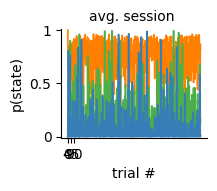

In [39]:
    # Now plot avg session:
    posterior_probs_mat = []
    for i, sess in enumerate(all_bins):
        idx_bin = np.where(bin_data == sess)
        posterior_probs_this_bin = posterior_probs[idx_bin[0], :]
        posterior_probs_mat.append(posterior_probs_this_bin)
    posterior_probs_mat = np.array(posterior_probs_mat)
    avg_posterior = np.mean(posterior_probs_mat, axis=0)
    std_dev_posterior = np.std(posterior_probs_mat, axis=0)
    plt.subplot(3, 3, 7)
    for k in range(K):
        plt.plot(avg_posterior[:, k], label="State " + str(k + 1), lw=1,
                 color=cols[k])
        se = std_dev_posterior[:, k] / np.sqrt(posterior_probs_mat.shape[0])
        plt.plot(avg_posterior[:, k] + se, color=cols[k], alpha=0.2)
        plt.plot(avg_posterior[:, k] - se, color=cols[k], alpha=0.2)

    plt.xticks([0, 45, 90], ["", "", ""], fontsize=10)
    plt.yticks([0, 0.5, 1], ["", "", ""], fontsize=10)
    plt.ylim((-0.01, 1.01))
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.title("avg. session ", fontsize=10)
    plt.xlabel("trial #", fontsize=10)
    plt.ylabel("p(state)", fontsize=10)
    plt.xticks([0, 45, 90], ["0", "45", "90"], fontsize=10)
    plt.yticks([0, 0.5, 1], ["0", "0.5", "1"], fontsize=10)
    fig.savefig(figure_dir + 'fig3abc.pdf')


In [38]:
posterior_probs_mat

array([], dtype=float64)